In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys, os
root = os.path.join(os.getcwd(), '../../')
sys.path.append(root)

import math
import numpy as np

DISTGEN_INPUT_FILE = os.path.join(root, 'templates/sectormagnet/distgen.in.yaml')

['screen("wcs", 0, 0, 0.0, 1, 0, 0, 0, 1, 0, 1.0);']

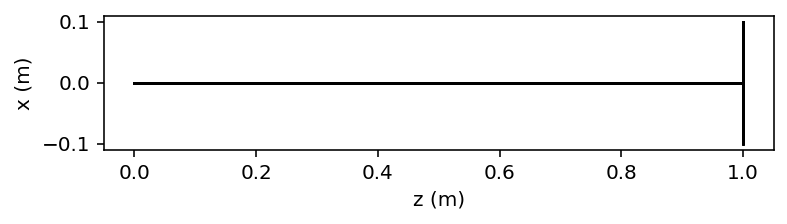

In [2]:
from gpt.element import Screen, Lattice

lat = Lattice('Single Bend')
lat.add(Screen('s1'), ds=1)
lat.plot_floor();

lat[-1].gpt_lines()

In [3]:
from distgen import Generator
from distgen.physical_constants import unit_registry
from gpt import GPT

gen = Generator(DISTGEN_INPUT_FILE, verbose=0)

gen.input['r_dist']={'type':'radial_uniform', 'min_r': 0*unit_registry('m'), 'max_r': 1*unit_registry('mm')}
gen.input['px_dist']={'type':'gaussian', 'sigma_px':500*unit_registry('eV/c')}
gen.input['py_dist']={'type':'gaussian', 'sigma_py':500*unit_registry('eV/c')}

set_pz = {
    'type': 'set_avg pz', 
    'avg_pz':{'value':+1, 'units':'GeV/c'}
}

twiss_x = {
    'type':'set_twiss x', 
    'beta': {'value':12.5, 'units':'m',},
    'alpha':{'value':0, 'units':''},
    'emittance': {'value':2, 'units':'um'}
}

gen.input['transforms']={'pz':set_pz, 'twiss':twiss_x, 'order':['pz','twiss']}
gen['n_particle']=1000
gen.run()

lat.write_gpt_lines(output_file='gpt.temp.in')

G = GPT(input_file='gpt.temp.in', initial_particles=gen.particles)
G.run()

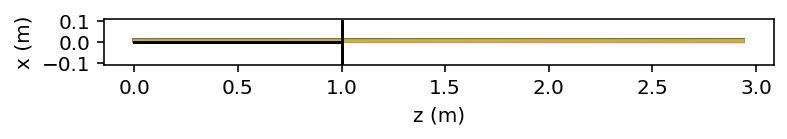

In [4]:
t1 = G.trajectory(1, data_type='tout')
fig = plt.figure()
ax = fig.add_subplot(111)

legend = []

for ii in range(0,70):
    tii = G.trajectory(ii, data_type='tout')
    if(tii):
        plt.plot(tii['z'], tii['x'])

plt.xlabel('z (m)');
plt.ylabel('x (m)');
lat.plot_floor(axis='equal');

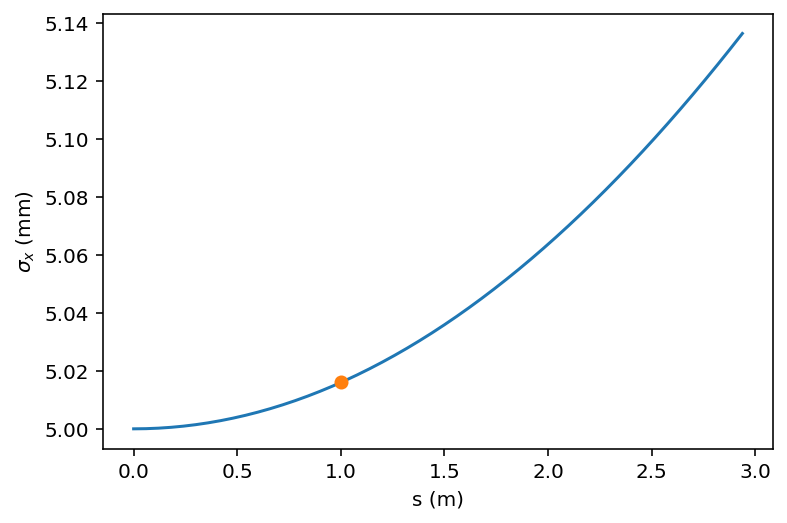

In [5]:
plt.plot(G.tout_stat('mean_z'), 
         G.tout_stat('sigma_x')*1000, 
         G.screen_stat('mean_z'),
         G.screen_stat('sigma_x')*1000,'o');
plt.xlabel('s (m)');
plt.ylabel('$\sigma_x$ (mm)');

In [6]:
from gpt.bstatic import Sectormagnet

gen = Generator(DISTGEN_INPUT_FILE, verbose=0)

set_pz = {'type': 'set_avg pz', 'avg_pz':{'value':+1, 'units':'GeV/c'}}

gen.input['transforms']={'pz':set_pz}
gen['n_particle']=10
gen.run()

R=1
p = gen.particles['mean_p']

lat2 = Lattice('L2')
lat2.add(Sectormagnet('b1', R, 90, p, phi_in=+45, phi_out=+45, width=0.4, fix=True), ds=0.25)
lat2.add(Screen('s1'), ds=1)
lat2['b1']._B=0.9*(lat2['b1']._B)
lat2.write_gpt_lines(output_file='gpt.temp.in')

with open('gpt.temp.in','a') as fid:
    fid.write('zminmax("b1_ccs_end", 0,0,0, 1,0,0, 0,1,0, -1, 1.1);\n')
    
G = GPT(input_file='gpt.temp.in', initial_particles=gen.particles, workdir='temp', use_tempdir=False)
G.set_variable('space_charge',0)
G.set_variable('tmax',1.2e-8)
G.run()

Screen s: 2.8207963267948966
Screen s error: [1.57433986e-14] %
avg_x: [-0.29580997]
Screen x position error: [3.75316296e-14] %


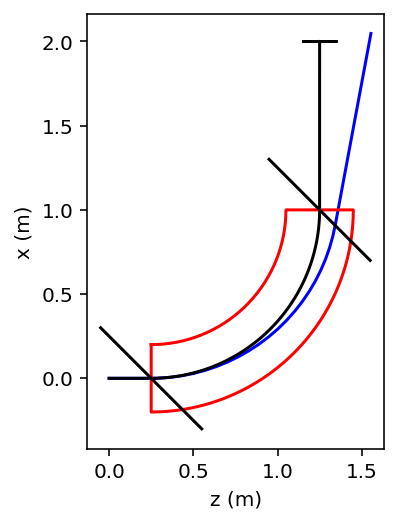

In [7]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_x'), 'b')
plt.xlabel('z (m)');
plt.ylabel('x (m)');
lat2.plot_floor(axis='equal');

print('Screen s:',lat2[-1].s_beg)
print('Screen s error:', 100*(G.screen_stat('mean_z')-lat2[-1].s_beg)/lat2[-1].s_beg, '%')
print('avg_x:', G.stat('mean_x','screen'))

z = G.stat('mean_z', 'tout')
x = G.stat('mean_x', 'tout')

xscreen = G.stat('mean_x','screen')
xtout = -(np.interp(2, x, z)-1.25)

print('Screen x position error:', 100*(xscreen-xtout)/xtout, '%')

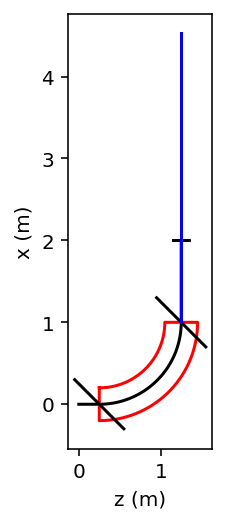

In [8]:
lat2.write_gpt_lines(output_file='gpt.temp.in')

G = GPT(input_file='gpt.temp.in', initial_particles=gen.particles, ccs_beg=lat2['b1'].ccs_end)
G.set_variable('space_charge',0)
G.set_variable('tmax',1.2e-8)
G.run()

lat2.plot_floor(axis='equal');

plt.plot(G.stat('mean_z','tout'), G.stat('mean_x','tout'), 'b')
plt.xlabel('z (m)');
plt.ylabel('x (m)');


In [9]:
os.remove('gpt.temp.in');